In [1]:
!pip install ultralytics
import os, shutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [2]:
# Define paths to the C2A dataset
base_path = "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3"
train_img_dir = os.path.join(base_path, "train", "images")
train_lbl_dir = os.path.join(base_path, "train", "labels")
val_img_dir   = os.path.join(base_path, "val", "images")
val_lbl_dir   = os.path.join(base_path, "val", "labels")

# Create a working directory for the filtered flood-only dataset
work_dir = "/kaggle/working/flood_yolo"
for subdir in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(work_dir, subdir), exist_ok=True)

In [3]:
# Filter flood images in training set
flood_train_imgs = [f for f in os.listdir(train_img_dir) if f.startswith("flood_image")]
# Filter flood images in validation set
flood_val_imgs = [f for f in os.listdir(val_img_dir) if f.startswith("flood_image")]

print(f"Found {len(flood_train_imgs)} flood training images and {len(flood_val_imgs)} flood validation images.")

# Copy filtered images and labels into the working directory
for img_file in flood_train_imgs:
    # Define source paths
    src_img = os.path.join(train_img_dir, img_file)
    src_lbl = os.path.join(train_lbl_dir, img_file.replace(".png", ".txt"))
    # Define destination paths
    dst_img = os.path.join(work_dir, "images/train", img_file)
    dst_lbl = os.path.join(work_dir, "labels/train", img_file.replace(".png", ".txt"))
    # Copy the files
    shutil.copy(src_img, dst_img)
    shutil.copy(src_lbl, dst_lbl)

for img_file in flood_val_imgs:
    src_img = os.path.join(val_img_dir, img_file)
    src_lbl = os.path.join(val_lbl_dir, img_file.replace(".png", ".txt"))
    dst_img = os.path.join(work_dir, "images/val", img_file)
    dst_lbl = os.path.join(work_dir, "labels/val", img_file.replace(".png", ".txt"))
    shutil.copy(src_img, dst_img)
    shutil.copy(src_lbl, dst_lbl)

Found 1529 flood training images and 542 flood validation images.


In [4]:
# Create a dataset YAML file for the flood subset
dataset_yaml = f"""
path: {work_dir}
train: images/train
val: images/val
names:
  0: human
"""
with open(os.path.join(work_dir, "flood.yaml"), "w") as f:
    f.write(dataset_yaml)
print("Flood-only dataset YAML created at", os.path.join(work_dir, "flood.yaml"))

Flood-only dataset YAML created at /kaggle/working/flood_yolo/flood.yaml


In [5]:
from ultralytics import YOLO
# Load pretrained RT-DETR (official HF version)
model = YOLO("yolo11s.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
results = model.train(
    data=os.path.join(work_dir, "flood.yaml"),  # use the flood-only dataset
    epochs=50,
    batch=4,
    imgsz=960,
    workers=2,
    lr0=0.01,               # Initial learning rate
    lrf=0.01,               # Final learning rate fraction (end of cosine schedule)
    momentum=0.937,         # Momentum for optimizer
    weight_decay=0.0005,    # Helps regularization
    warmup_epochs=3,        # Warmup for stable initial convergence
    augment=True,
    #optimizer="AdamW",
    patience=10,       # early stopping if no improvement
    #close_mosaic=10,  # disable mosaic augmentation after 10 epochs
    #degrees=20,       # augmentation: rotation range
    #translate=0.2,    # augmentation: translation
    #scale=0.5,        # augmentation: scale (zoom) range
    #shear=10,         # augmentation: shear angle
    #flipud=0.1,       # augmentation: vertical flip probability
    #hsv_h=0.015,      # augmentation: HSV hue
    #hsv_s=0.7,        # augmentation: HSV saturation
    #hsv_v=0.4         # augmentation: HSV value (brightness)
)

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/flood_yolo/flood.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        542      18562      0.836      0.765      0.819      0.576
Speed: 0.4ms preprocess, 27.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


In [7]:
#  ✅Get path from results object
best_model_path = os.path.join(results.save_dir, "weights", "best.pt")

# ✅ Copy to a fixed known location
shutil.copy(best_model_path, "/kaggle/working/flood_best.pt")
print("Finetuned model saved to /kaggle/working/flood_best.pt")

Finetuned model saved to /kaggle/working/flood_best.pt


In [8]:
# Load the best model
ft_model = YOLO("/kaggle/working/flood_best.pt")

# Validate on the flood val set again
ft_metrics = ft_model.val(data=os.path.join(work_dir, "flood.yaml"), split="val", imgsz=960, batch=4)

# Extract metrics
ft_precision = ft_metrics.box.mp
ft_recall    = ft_metrics.box.mr
ft_map50     = ft_metrics.box.map50
ft_map5095   = ft_metrics.box.map

print(f"Precision: {ft_precision:.4f}")
print(f"Recall: {ft_recall:.4f}")
print(f"mAP@0.5: {ft_map50:.4f}")
print(f"mAP@0.5:0.95: {ft_map5095:.4f}")


Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3342.5±969.3 MB/s, size: 856.0 KB)
val: Scanning /kaggle/working/flood_yolo/labels/val.cache... 542 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 542/542 1.1Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 136/136 8.9it/s 15.3s0.1s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        542      18562      0.875      0.762       0.83      0.597
Speed: 0.5ms preprocess, 20.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
Precision: 0.8749
Recall: 0.7617
mAP@0.5: 0.8300
mAP@0.5:0.95: 0.5970



image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0202_4.png: 960x960 30 humans, 29.2ms
Speed: 5.3ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 960, 960)


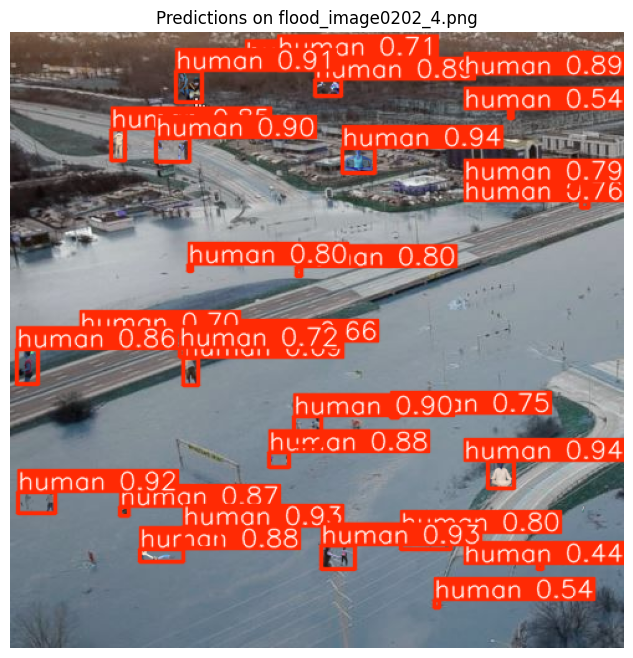


image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0392_4.png: 960x960 32 humans, 29.2ms
Speed: 6.3ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 960, 960)


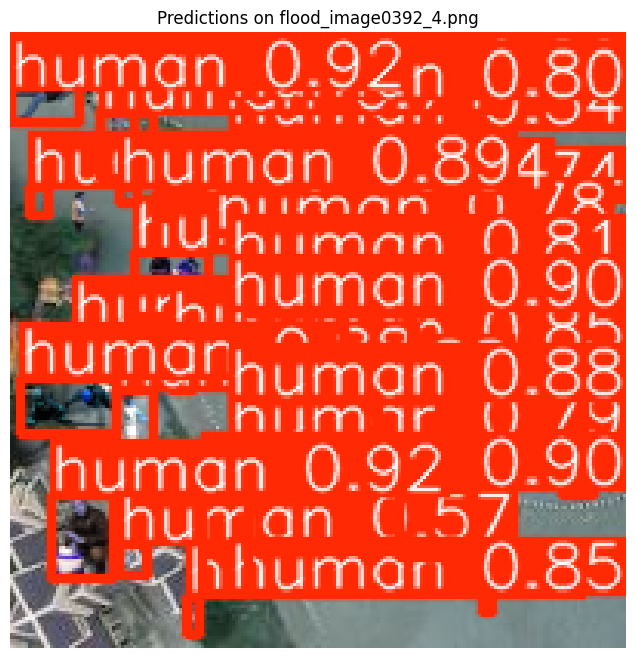


image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0178_3.png: 864x960 31 humans, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.4ms postprocess per image at shape (1, 3, 864, 960)


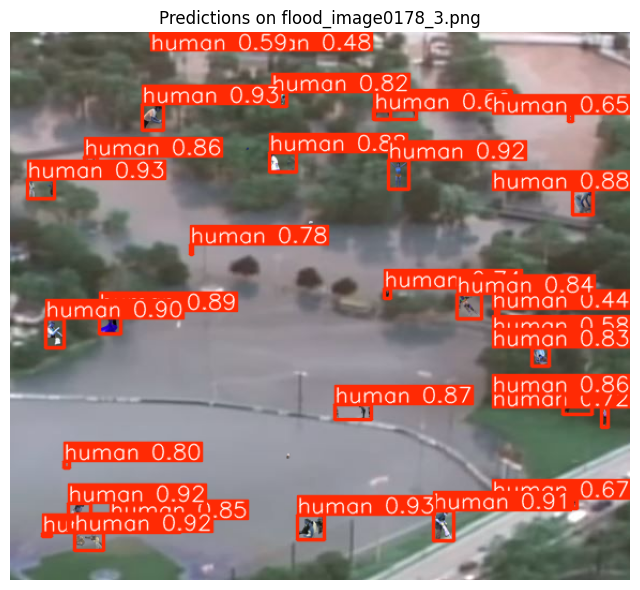


image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0218_4.png: 960x960 21 humans, 29.9ms
Speed: 4.9ms preprocess, 29.9ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)


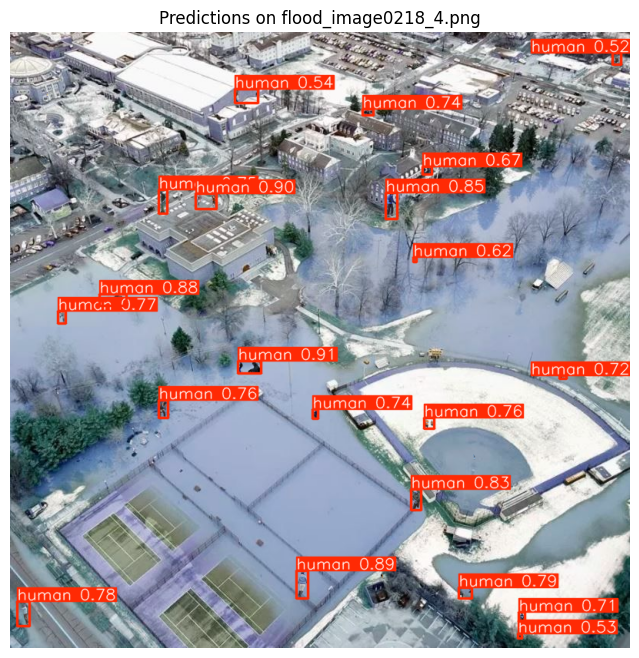


image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0526_2.png: 960x960 30 humans, 29.2ms
Speed: 6.1ms preprocess, 29.2ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 960)


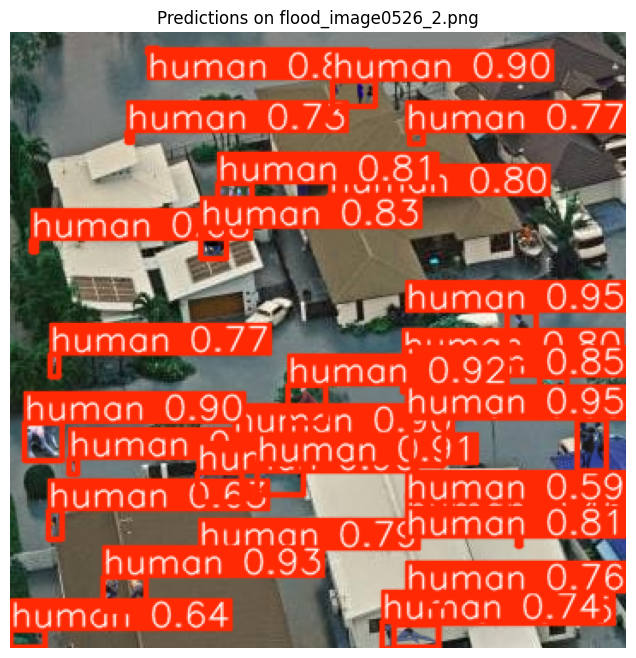

In [9]:
import matplotlib.pyplot as plt
import random

val_images_dir = os.path.join(work_dir, "images/val")
val_images = os.listdir(val_images_dir)
sample_imgs = random.sample(val_images, 5)  # pick 5 random validation images

for img_file in sample_imgs:
    img_path = os.path.join(val_images_dir, img_file)
    results = ft_model.predict(source=img_path, conf=0.4)  # get predictions (conf=0.4 threshold)
    plotted_img = results[0].plot()  # draw boxes on the image
    
    # Display the image with detections
    plt.figure(figsize=(8, 8))
    plt.imshow(plotted_img)
    plt.title(f"Predictions on {img_file}")
    plt.axis('off')
    plt.show()